<a href="https://colab.research.google.com/github/Eeaeau/TTT4135-Multimedia-Signal-Processing/blob/main/TTT4135_MULTIMEDIA_SIGNAL_PROCESSING_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import numpy as np
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt
import os
import cv2 as cv
from scipy import signal
from scipy import stats
import seaborn as sns
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time


sns.set_theme()

sns.set_style("dark")

# Task 1

## 1d

In [ ]:
mu =0
sigma = np.sqrt(1)

X = np.random.normal(mu, sigma, 200)

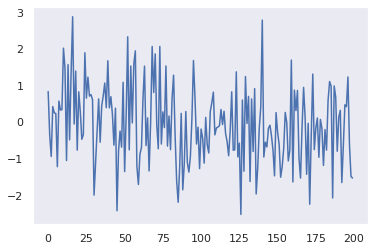

In [ ]:
plt.plot(X)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


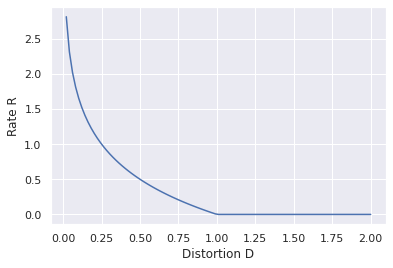

In [ ]:
D = np.linspace(0, 2*sigma, 100)

def rate_distortion_square_error(D):
  return np.maximum(1/2*np.log2(sigma**2/D), 0)

fig, ax = plt.subplots()

ax.set_xlabel("Distortion D")
ax.set_ylabel("Rate R")
ax.grid()

ax.plot(D, rate_distortion_square_error(D))
plt.savefig("1d_RD.eps")
plt.savefig("1d_RD.png")
plt.show()

## 1e

In [ ]:
def quantize_uniform(x, quant_min=0, quant_max=1.0, bits=5):
  """
  Args:
        x (np.ndarray): Original signal
        quant_min (float): Minimum quantization level (Default value = -1.0)
        quant_max (float): Maximum quantization level (Default value = 1.0)
        bits (int): Number of quantization levels (Default value = 5)
  """
  quant_level = 2**bits
  x_normalize = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
  x_normalize[x_normalize > quant_level - 1] = quant_level - 1
  x_normalize[x_normalize < 0] = 0
  x_normalize_quant = np.around(x_normalize)
  x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
  return x_quant

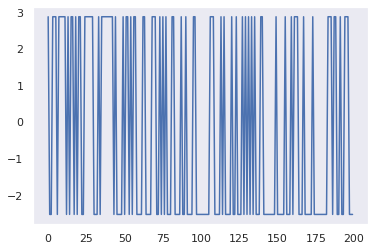

In [ ]:
X_1bits = quantize_uniform(X,np.min(X), np.max(X), 1) # although not optimal, we are here simplifiying by just taking min and max as limits
X_2bits = quantize_uniform(X,np.min(X), np.max(X), 2)
X_3bits = quantize_uniform(X,np.min(X), np.max(X), 3)

plt.plot(X_1bits)

In [ ]:
def distortion(x, x_quantized_estimate):
  return np.mean(np.square(x - x_quantized_estimate))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


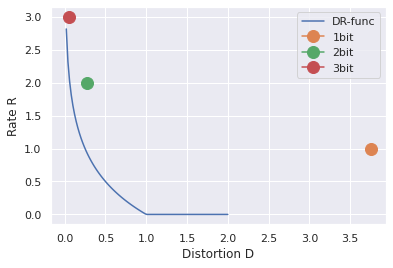

In [ ]:
RD_pair_1bit = (1, distortion(X , X_1bits))
RD_pair_2bit = (2, distortion(X , X_2bits))
RD_pair_3bit = (3, distortion(X , X_3bits))


fig, ax = plt.subplots()

ax.set_xlabel("Distortion D")
ax.set_ylabel("Rate R")
ax.grid()

ax.plot(D, rate_distortion_square_error(D))
ax.plot(RD_pair_1bit[1], RD_pair_1bit[0], marker='o', markersize=12)
ax.plot(RD_pair_2bit[1], RD_pair_2bit[0], marker='o', markersize=12)
ax.plot(RD_pair_3bit[1], RD_pair_3bit[0], marker='o', markersize=12)

ax.legend(["DR-func", "1bit", "2bit", "3bit"])
plt.savefig("1e_RD.eps")
plt.savefig("1e_RD.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


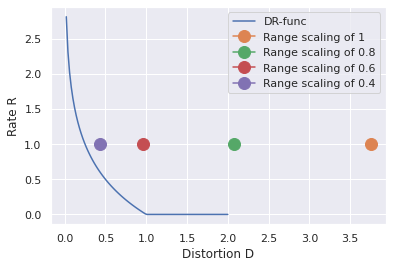

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


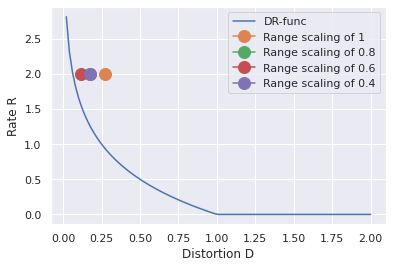

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


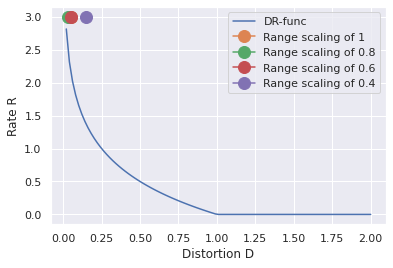

In [ ]:
bit_rates = [1, 2, 3]
ranges = [1, 0.8, 0.6, 0.4]

for bit in bit_rates:
  fig, ax = plt.subplots()

  ax.set_xlabel("Distortion D")
  ax.set_ylabel("Rate R")
  ax.grid()
  legend_strings = ["DR-func"]
  ax.plot(D, rate_distortion_square_error(D))

  for range in ranges:
    legend_strings.append("Range scaling of "+str(range))

    RD_pair_uniform = (bit, distortion(X, quantize_uniform(X, range*np.min(X), range*np.max(X), bit)))

    ax.plot(RD_pair_uniform[1], RD_pair_uniform[0], marker='o', markersize=12)

  # ax.title("bit rate:"+str(bit))
  ax.legend(legend_strings)
  plt.savefig("1e_RD"+str(bit)+"bit.eps")
  plt.savefig("1e_RD"+str(bit)+"bit.png")
  plt.show()

## 1f

In [ ]:
def encoding_mu_law(v, mu=255.0):
    """mu-law encoding
    Args:
        v (float): Value between -1 and 1
        mu (float): Encoding parameter (Default value = 255.0)

    Returns:
        v_encode (float): Encoded value
    """
    v_encode = np.sign(v) * (np.log(1.0 + mu * np.abs(v)) / np.log(1.0 + mu))
    return v_encode

def decoding_mu_law(v, mu=255.0):
    """mu-law decoding
    Args:
        v (float): Value between -1 and 1
        mu (float): Dencoding parameter (Default value = 255.0)

    Returns:
        v_decode (float): Decoded value
    """
    v_decode = np.sign(v) * (1.0 / mu) * ((1.0 + mu)**np.abs(v) - 1.0)
    return v_decode

In [ ]:
def quantize_nonuniform_tanh(x, max_amplitude=1, squeeze=1, bits=5):
  """
  Description:
        Quantizise based on gaussian pdf
  Args:
        x (np.ndarray): Original signal
        quant_min (float): Minimum quantization level (Default value = -1.0)
        quant_max (float): Maximum quantization level (Default value = 1.0)
        bits (int): Number of quantization levels (Default value = 5)
  """

  x_en = np.tanh(squeeze*x)
  x_en_quant = quantize_uniform(x_en, quant_min=-max_amplitude, quant_max=max_amplitude, bits=bits)
  x_quant = np.arctanh(x_en_quant)
  return x_quant

In [ ]:
def quantize_nonuniform_mu(x, mu=64.0, bits=8):
    """Nonuniform quantization approach using mu-encoding

    Notebook: C2/C2S2_DigitalSignalQuantization.ipynb

    Args:
        x (np.ndarray): Original signal
        mu (float): Encoding parameter (Default value = 4.0)
        bits (int): Number of quantization levels (Default value = 64)

    Returns:
        x_quant (np.ndarray): Quantized signal
    """
    x_encoded = encoding_mu_law(x, mu=mu)
    x_encoded_quant = quantize_uniform(x_encoded, quant_min=-1, quant_max=1, bits=bits)
    x_decoded = decoding_mu_law(x_encoded_quant, mu=mu)
    return x_decoded

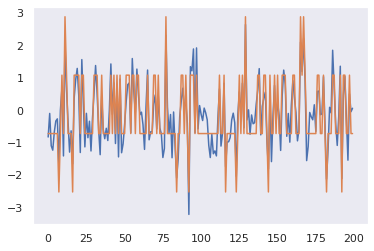

In [ ]:
Y = np.random.normal(mu, sigma, 200)
plt.plot(Y)
plt.plot(quantize_uniform(Y, np.min(X), np.max(X), 2)) # although not optimal, we are here simplifiying by just taking min and max as limits


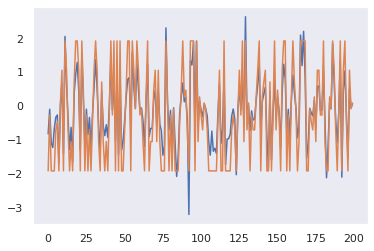

In [ ]:
plt.plot(Y)
plt.plot(quantize_nonuniform_tanh(Y, 2.7, 2))
plt.show()

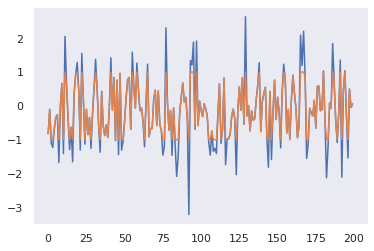

In [ ]:
plt.plot(Y)
plt.plot(quantize_nonuniform_mu(Y))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


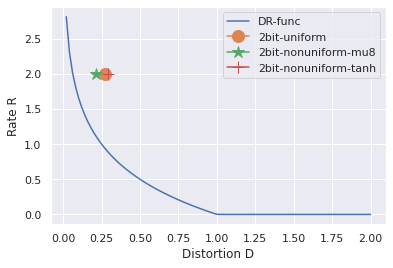

In [ ]:
mu = 8
X_2bit_mu = quantize_nonuniform_mu(X, mu, 2)
X_2bit_tanh = quantize_nonuniform_tanh(X, 2.6, 2)
RD_pair_2bit_mu = (2, distortion(X, X_2bit_mu))
RD_pair_2bit_tanh = (2, distortion(X, X_2bit_tanh))


fig, ax = plt.subplots()

ax.set_xlabel("Distortion D")
ax.set_ylabel("Rate R")
ax.grid()

ax.plot(D, rate_distortion_square_error(D))
ax.plot(RD_pair_2bit[1], RD_pair_2bit[0], marker='o', markersize=12)
ax.plot(RD_pair_2bit_mu[1], RD_pair_2bit_mu[0], marker='*', markersize=12)
ax.plot(RD_pair_2bit_tanh[1], RD_pair_2bit_tanh[0], marker='+', markersize=12)

ax.legend(["DR-func", "2bit-uniform", "2bit-nonuniform-mu"+str(mu), "2bit-nonuniform-tanh"])
plt.savefig("1f_RD.eps")
plt.savefig("1f_RD.png")
plt.show()

In [ ]:


# X_2bit_uniform = quantize_uniform(X, 0.6*np.min(X), 0.6*np.max(X), 2)
# X_2bit_mu = quantize_nonuniform_mu(X, 0.6*np.min(X), 0.6*np.max(X), 4, 2)

# X_2bit_tanh = quantize_nonuniform_tanh(X, 2.6, 2)

# RD_pair_2bit_uniform = (2, distortion(X, X_2bit_uniform))
# RD_pair_2bit_mu = (2, distortion(X, X_2bit_mu))
# RD_pair_2bit_tanh = (2, distortion(X, X_2bit_tanh))


# fig, ax = plt.subplots()

# ax.set_xlabel("Distortion D")
# ax.set_ylabel("Rate R")
# ax.grid()

# ax.plot(D, rate_distortion_square_error(D))
# ax.plot(RD_pair_2bit_uniform[1], RD_pair_2bit_uniform[0], marker='o', markersize=12)
# ax.plot(RD_pair_2bit_mu[1], RD_pair_2bit_mu[0], marker='*', markersize=12)
# ax.plot(RD_pair_2bit_tanh[1], RD_pair_2bit_tanh[0], marker='+', markersize=12)

# ax.legend(["DR-func", "2bit-uniform", "2bit-nonuniform-mu", "2bit-nonuniform-tanh"])
# plt.savefig("1f_RD.eps")
# plt.savefig("1f_RD.png")
# plt.show()

## 1g

In [ ]:
n_bits=2
n_clusters=n_bits**2

X_2D=np.reshape(X, (X.size, 1))

# print(X_2D)
kmeans = KMeans(n_clusters=n_clusters).fit(X_2D)

In [ ]:
values = kmeans.cluster_centers_.squeeze()
labels = kmeans.labels_

print(labels)
print(values)

[1 3 3 1 1 1 0 1 1 1 2 2 0 2 3 2 2 3 2 3 1 1 3 3 2 1 2 1 1 1 0 0 3 1 3 1 1
 1 1 2 1 1 1 3 1 0 3 3 3 1 0 1 2 3 2 3 2 2 0 0 3 3 1 2 3 1 0 3 2 1 2 3 3 2
 3 1 3 2 3 1 3 1 2 3 0 0 0 1 0 0 1 0 0 3 1 2 1 3 3 0 3 3 0 1 3 3 1 1 1 3 3
 3 3 1 3 1 3 3 3 3 1 3 3 2 3 3 0 1 0 2 3 1 0 1 3 1 0 0 3 1 2 3 3 3 3 3 3 3
 0 1 3 3 0 0 3 1 3 0 3 2 0 1 1 1 3 0 3 1 1 0 3 0 3 2 3 3 1 3 1 3 0 3 3 1 1
 1 0 1 1 3 1 1 0 3 1 1 2 3 0 0]
[-1.5238547   0.51686525  1.71295806 -0.48589727]


In [ ]:
labels_pred = kmeans.predict(X_2D)
print(labels_pred.size)

200


In [ ]:
def recreate_signal(codebook, labels):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels]

In [ ]:
recreate_signal(values, labels_pred).shape
# plt.plot()

(200,)

(200,)


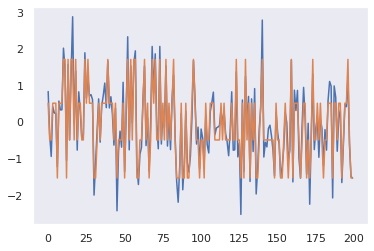

In [ ]:
print(X.shape)
plt.plot(X)
plt.plot(recreate_signal(values, labels_pred))

In [ ]:
def quantize_nonuniform_kmeans(x, n_bits=8):
  n_clusters=2**n_bits

  x_2D=np.reshape(x, (x.size, 1))
  kmeans = KMeans(n_clusters=n_clusters).fit(x_2D)
  values = kmeans.cluster_centers_.squeeze()
  labels_pred = kmeans.predict(X_2D)

  return recreate_signal(values, labels_pred)


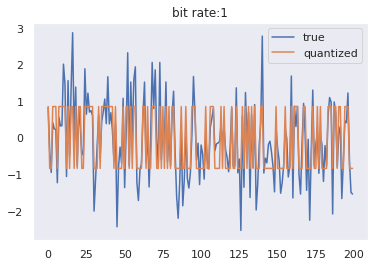

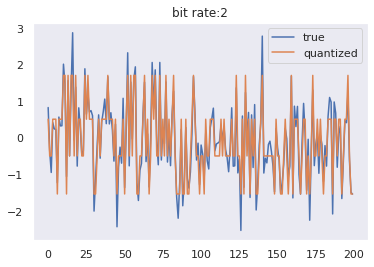

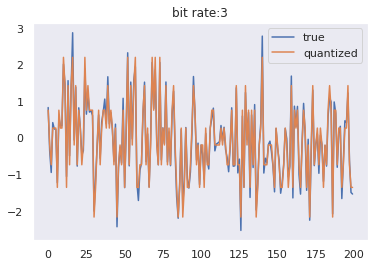

In [ ]:
bit_rates = [1, 2, 3]

for bit in bit_rates:
  plt.plot(X)
  plt.plot(quantize_nonuniform_kmeans(X, bit))
  plt.title("bit rate:"+str(bit))
  plt.legend(["true", "quantized"])
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


['DR-func', '1bit-uniform', '1bit-nonuniform-kmeans', '2bit-uniform', '2bit-nonuniform-kmeans', '3bit-uniform', '3bit-nonuniform-kmeans']


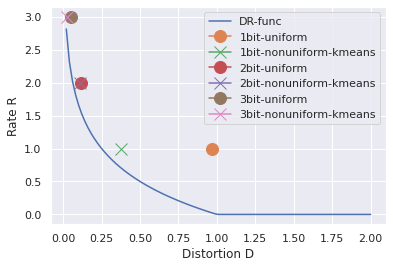

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel("Distortion D")
ax.set_ylabel("Rate R")
ax.grid()

ax.plot(D, rate_distortion_square_error(D))

legend_strings = ["DR-func"]
for bit in bit_rates:

  legend_strings.append(str(bit)+"bit-uniform")
  legend_strings.append(str(bit)+"bit-nonuniform-kmeans")

  RD_pair_uniform = (bit, distortion(X, quantize_uniform(X, 0.6*np.min(X), 0.6*np.max(X), bit)))
  RD_pair_kmeans = (bit, distortion(X, quantize_nonuniform_kmeans(X, bit)))

  ax.plot(RD_pair_uniform[1], RD_pair_uniform[0], marker='o', markersize=12)
  ax.plot(RD_pair_kmeans[1], RD_pair_kmeans[0], marker='x', markersize=12)

print(legend_strings)
ax.legend(legend_strings)
plt.savefig("1g_RD.eps")
plt.savefig("1g_RD.png")
plt.show()